In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.synonyms import toy_transformation
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.stats.h_testing import  LIMts_test
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1.0,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.718147118350231


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

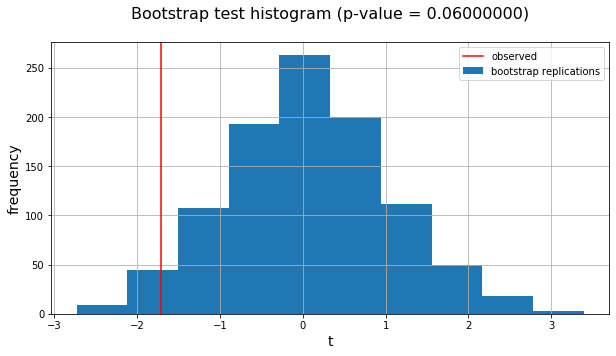

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [7]:
M,E,S = 5,2,1000


tests1 = LIMts_test(train=train,
                    dev=dev,
                    train_transformation=entailment_internalization,
                    dev_transformation=entailment_internalization,
                    rho=0.78,
                    Model=LRWrapper,
                    hyperparams=hyperparams,
                    M=M,
                    E=E,
                    S=S)

tests1

,m,train_accuracy_mean,train_accuracy_std,train_accuracy_ensemble,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,0.74375,0.0,0.74375,0.325,0.570,-8.056095,0.0,0.008339,0.142235,...,0.963754,-0.142864,1.183660,0.715199,0.468779,-1.265286,1.650919,0.288735,0.906390,-0.282899
1,2,0.75250,0.0,0.75250,0.325,0.555,-7.729182,0.0,0.010693,0.125319,...,-0.428768,0.145873,0.142864,0.152507,0.850060,0.000000,-0.577832,0.801927,-2.123977,1.439477
2,3,0.74750,0.0,0.74750,0.325,0.570,-8.056095,0.0,0.005926,0.127675,...,-0.343098,0.715199,-0.149079,-0.817861,-1.112830,1.873366,-2.292273,-1.303270,0.404686,0.301580
3,4,0.73750,0.0,0.73750,0.305,0.570,-8.491693,0.0,0.005984,0.101684,...,0.384252,1.792223,-0.428768,-0.730297,0.000000,0.789064,0.000000,0.662994,0.397517,-0.544735
4,5,0.75375,0.0,0.75375,0.300,0.540,-7.947194,0.0,0.006005,0.103209,...,0.282899,-0.294948,-0.898063,0.272216,-0.149079,-0.288735,0.246220,0.140035,0.886388,0.288735


### Diferent bootstrap distributions for each experiment

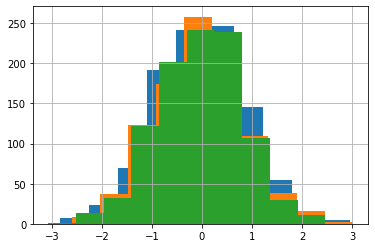

In [8]:
tests1.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

**test2: toy transformation**

In [9]:
tests2 = LIMts_test(train=train,
                   dev=dev,
                   train_transformation=toy_transformation,
                   dev_transformation=toy_transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=1,
                   S=S)

tests2

,m,train_accuracy_mean,train_accuracy_std,train_accuracy_ensemble,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,0.63875,0.0,0.63875,0.230,0.220,0.707992,0.488,0.007718,0.054796,...,-0.378100,0.707992,0.447437,-0.277403,0.707992,0.000000,0.378100,1.270001,2.264554,0.000000
1,2,0.64875,0.0,0.64875,0.195,0.230,-1.960008,0.062,0.003507,0.040737,...,-0.775761,-0.906390,-0.896221,-1.002509,0.301580,-0.833494,0.906390,0.000000,-2.020305,0.000000
2,3,0.64625,0.0,0.64625,0.220,0.220,0.000000,0.790,0.004069,0.042897,...,0.577832,1.347719,-2.264554,1.421338,-0.447437,2.487080,-1.002509,0.906390,-1.002509,1.002509
3,4,0.65000,0.0,0.65000,0.225,0.230,-0.447437,0.790,0.003581,0.041727,...,0.577832,0.817861,-1.002509,-1.270001,1.643990,-0.817861,-1.745189,-1.421338,-1.421338,1.347719
4,5,0.64500,0.0,0.64500,0.215,0.215,0.000000,0.908,0.003597,0.042431,...,0.633089,-0.577832,0.378100,-1.270001,-0.301580,-0.707992,1.002509,-0.447437,-0.447437,0.000000


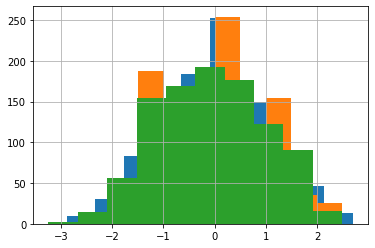

In [10]:
tests2.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

In [12]:
assert np.any(tests1.p_value < (0.05/M))
assert not np.any(tests2.p_value < (0.05/M))

In [14]:
tests2.p_value

0    0.488
1    0.062
2    0.790
3    0.790
4    0.908
Name: p_value, dtype: float64